# Galaxies and QSOs with neural network
Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [40]:
import numpy as np
import pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data as torchdata
from torch.utils.data import Dataset, DataLoader
from astroML.utils.decorators import pickle_results
from sklearn.metrics import roc_curve, auc

In [2]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6), dtype=float)
data.shape

(50000, 6)

In [3]:
#Extract data in each band and redshifts
u = data[:, 0]
g = data[:, 1]
r = data[:, 2]
i = data[:, 3]
z = data[:, 4]
z1 = data[:, 5]

In [4]:
#Colors
u_g = u-g
g_r = g-r
r_i = r-i
i_z = i-z
colors = np.array([u_g, g_r, r_i, i_z]).T

In [5]:
labels=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)

types = np.empty(shape = labels.size)     #Class labels

for i, label in enumerate(labels):
    if (label == 'GALAXY'): types[i] = 0
    elif (label == 'QSO'): types[i] = 1

We need first to scale the data for a better fit.

In [6]:
scaler = StandardScaler()
colors_scaled = scaler.fit_transform(colors)

Now we split the rescaled data.

In [7]:
#Split data into training & testing sets
colors_train, colors_test, types_train, types_test = train_test_split(colors_scaled, types, test_size=0.3, random_state=0)

In [36]:
#Create datasets
train_dataset = torchdata.TensorDataset(torch.tensor(colors_train, dtype=torch.float32), torch.tensor(types_train, dtype=torch.float32).view(-1, 1))
test_dataset = torchdata.TensorDataset(torch.tensor(colors_test, dtype=torch.float32), torch.tensor(types_test, dtype=torch.float32).view(-1, 1))

#Create dataloaders
train_loader = torchdata.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torchdata.DataLoader(test_dataset, batch_size=128, shuffle=False)  # Usually no need to shuffle test data

## Neural Network with one hidden layer with 5 neurons

In [37]:
# Define the neural network
class NeuralNet_simple(nn.Module):
    def __init__(self):
        super(NeuralNet_simple, self).__init__()
        self.layer1 = nn.Linear(4, 5)    # First hidden layer: 4=input, 5=output
        self.out = nn.Linear(5, 1)       # Output layer: 5=input, 1=output
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.out(x)               
        return x

Define the function for training.

In [38]:
@pickle_results('NNTypes.pkl')
def train_model():
    model = NeuralNet_simple()
    criterion = torch.nn.MSELoss(reduction='sum') #Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    min_valid_loss = float('inf')
    badepochs = 0
     #Adaptive learning rate...
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(train_loader, 0):
            colors, types = databatch
            optimizer.zero_grad()
            type_pred = model(colors)
            loss = criterion(type_pred, types)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        with torch.no_grad():
            colors = test_dataset[:][0]
            types = test_dataset[:][1]
            type_pred = model(colors)
            valid_loss = criterion(type_pred, types)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(colors_train), valid_loss / len(colors_test)))
            #Stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [39]:
model = train_model()

@pickle_results: computing results and saving to 'NNTypes.pkl'
Epoch   0: train loss 2.099e-01 validation loss 9.796e-02
Epoch  10: train loss 3.555e-02 validation loss 3.614e-02
Epoch  20: train loss 3.337e-02 validation loss 3.571e-02
Finished training


In [71]:
#Function for the roc curves
def plot_roc_curves(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    
    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []
    
    # Gather predictions
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            predictions = torch.sigmoid(outputs)  
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    y_pred = np.array(all_predictions)
    y_true = np.array(all_labels)
    
    # Calculate ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc, fpr, tpr

AUC Score: 0.975


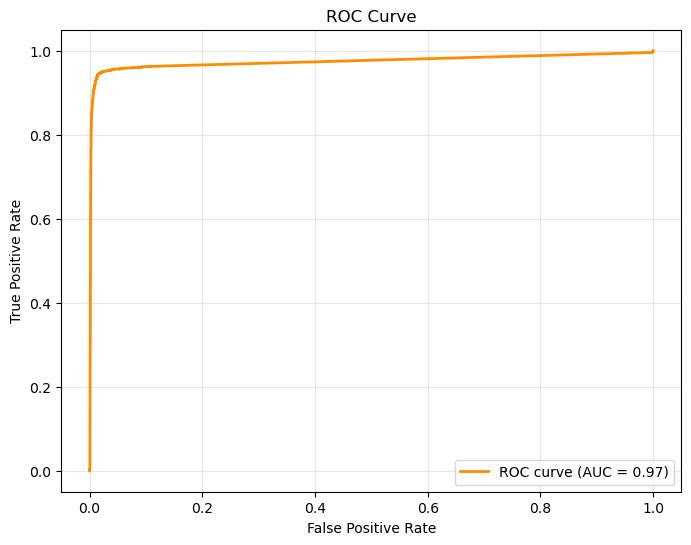

In [79]:
#Plot the ROC curves
auc_score, fpr, tpr = plot_roc_curves(model, test_loader)
print(f'AUC Score: {auc_score:.3f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(c='grey', alpha = 0.2)
plt.show()

## Neural Network implementation

We define the neural network. We have 4 input layers (4 colors), 1 output layer (QSO or galaxy) and we choose 2 hidden layers: the first with 8 nodes and the second with 4 nodes.

In [61]:
# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(4, 8)  #First hidden layer: 4=input, 8=output
        self.layer2 = nn.Linear(8, 4)  #Second hidden layer: 8=input, 4=output
        self.out = nn.Linear(4, 1)  #Output layer: 4=input, 1=output
        
        self.relu = nn.ReLU()          #Applies the rectified linear unit function element-wise.
        self.dropout = nn.Dropout(0.2) #During training, randomly zeroes some of the elements of the input tensor with probability p. This prevernts overfitting
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [62]:
@pickle_results('NNTypes2.pkl')
def train_model2():
    model2 = NeuralNet()
    criterion = torch.nn.MSELoss(reduction='sum') #Loss function
    optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
    
    min_valid_loss = float('inf')
    badepochs = 0
     #Adaptive learning rate...
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(train_loader, 0):
            colors, types = databatch
            optimizer.zero_grad()
            type_pred = model2(colors)
            loss = criterion(type_pred, types)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        with torch.no_grad():
            colors = test_dataset[:][0]
            types = test_dataset[:][1]
            type_pred = model2(colors)
            valid_loss = criterion(type_pred, types)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(colors_train), valid_loss / len(colors_test)))
            #Stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model2

In [64]:
model2 = train_model2()

@pickle_results: computing results and saving to 'NNTypes2.pkl'


C:\Users\ISAFA\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   0: train loss 2.006e-01 validation loss 1.156e-01
Epoch  10: train loss 3.532e-02 validation loss 3.472e-02
Epoch  20: train loss 2.927e-02 validation loss 3.130e-02
Epoch  30: train loss 2.902e-02 validation loss 2.985e-02
Epoch  40: train loss 2.745e-02 validation loss 2.769e-02
Finished training


AUC Score: 0.974


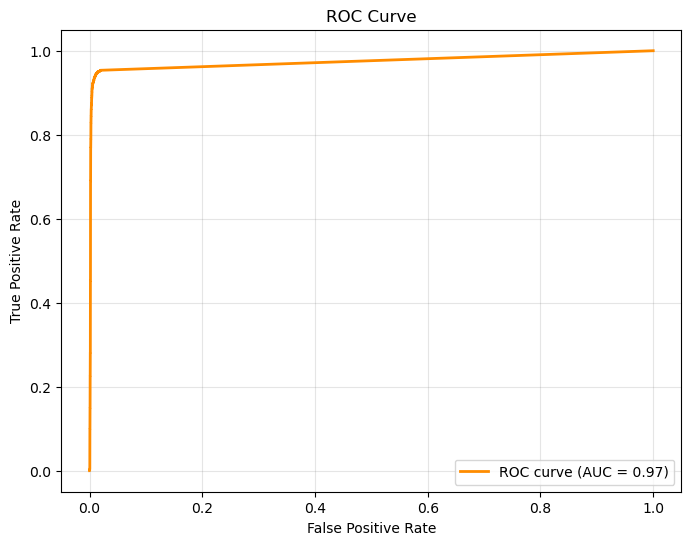

In [80]:
auc_score2, fpr2, tpr2 = plot_roc_curves(model2, test_loader)
print(f'AUC Score: {auc_score2:.3f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {auc_score2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(c='grey', alpha = 0.2)
plt.show()

Plot the ROC curves together.

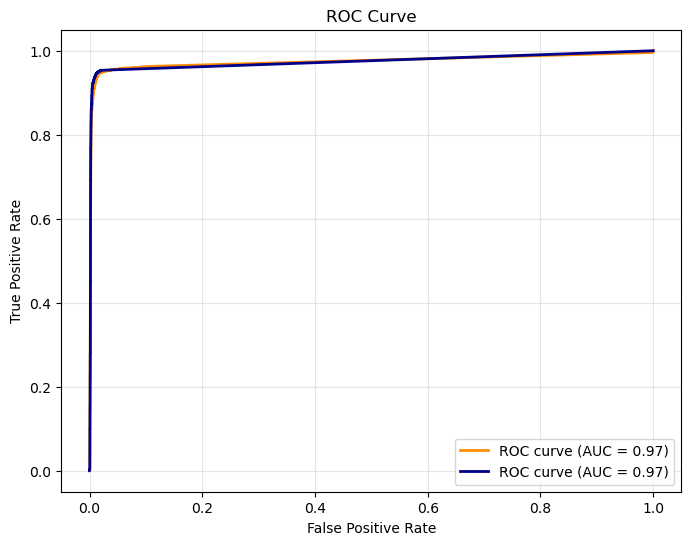

In [83]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.plot(fpr2, tpr2, color='darkblue', lw=2, 
         label=f'ROC curve (AUC = {auc_score2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(c='grey', alpha = 0.2)
plt.show()

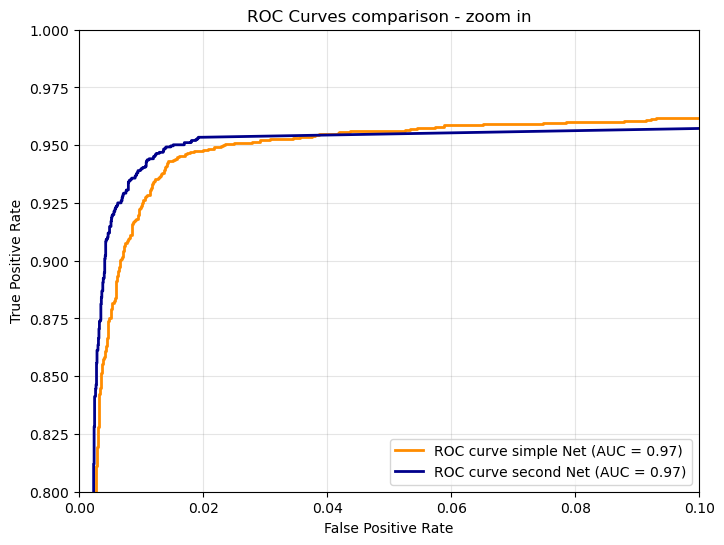

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve simple Net (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves comparison - zoom in')
plt.grid(c='grey', alpha = 0.2)

plt.plot(fpr2, tpr2, color='darkblue', lw=2, 
         label=f'ROC curve second Net (AUC = {auc_score2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.xlim(0, 0.1)
plt.ylim(0.8, 1)
plt.show()